In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time


In [66]:
start_time = time.time()


In [68]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' ## to ingnore some warning 

### Load the data 

In [44]:
Corpus = pd.read_csv("input/batches/email_batch_40.csv", encoding='latin')

Corpus

,email,category
0,this cp has merged into pancanadian energy ser...,0
1,this morning roman blake with calp told robin ...,0
2,kay please forward to max yzaguirre max congra...,0
3,k how s life back in texas i am not sure if i ...,0
4,sent on behalf of laurie pare attached is my m...,0
...,...,...
2853,on line gaming report special online issue inv...,1
2854,account suspension dear paypal user in accorda...,1
2855,small cap stoxs can mean gains for you watch t...,1
2856,roletes e roldanas para empilhadeiras santos j...,1


In [45]:
### The dataset has 2 class, which 0 is Email and 1 is spam 
### There are 2033 unique email out of 2087 
### There are 1356 unique spam out of 1360 

Corpus.groupby('category').describe()

email                                                               
         count unique                                                top freq
category                                                                     
0         1497   1469  start date hourahead hour no ancillary schedul...   13
1         1360   1355  at your serrvice hello welcome to ph elation a...    2

Text(0.5, 1.0, 'Number of Emails and Spams')

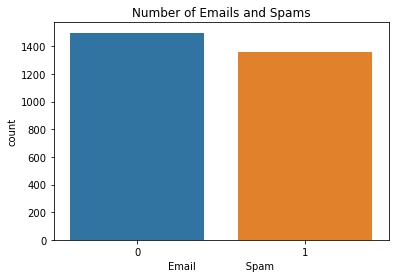

In [46]:
# Display
sns.countplot(Corpus.category)
plt.xlabel('Email                Spam')
plt.title('Number of Emails and Spams')

In [47]:
X = Corpus.email.astype(str) # data
Y = Corpus.category  # labels

In [48]:
# label enconder from pandas to an array
le = LabelEncoder()
Y = le.fit_transform(Y)

# transfor from a array to a vector
Y = Y.reshape(-1,1)

##### Splitting data 70% for training and 30% for testing

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=20)

In [50]:
X_train

458     attached is a revision of the advice letter su...
802     thought for today  whisper jesus   today i got...
543                             an april less version kay
938     thanks for your quick reply my apologies for a...
2499    looking for cheap high quality software softwa...
                              ...                        
1814    commission on month cd style annuity guarantee...
1428    original message from cooke ian sent thursday ...
2441    become happy with your performance male enhanc...
271     howdy how long has it been when are we going o...
2522    moore medz hello welcome to medzonline sho api...
Name: email, Length: 2286, dtype: object

In [51]:
max_words = 1000
max_len = 200
# Tokenize the data and convert the text to sequences.
tok = Tokenizer(num_words=max_words)

#Tokenize the data and convert the text to sequences.
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
# Add padding to ensure that all the sequences have the same shape.
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# Process the test set data.
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)



### Creating Functional LSTM model

In [69]:
def LSTM_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(260)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [73]:
# Call the function and compile the model.
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 200, 50)           50000     
_________________________________________________________________
lstm_53 (LSTM)               (None, 260)               323440    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               66816     
_________________________________________________________________
activation_105 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257

Fit on the training data.

In [74]:
history = model.fit(sequences_matrix,
                    Y_train,
                    batch_size=256,
                    epochs=20,
                    validation_split=0.2 )

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1828 samples, validate on 458 samples
Epoch 1/20
1828/1828 [==============================] - 45s 25ms/step - loss: 0.6874 - accuracy: 0.6275 - val_loss: 0.6682 - val_accuracy: 0.7140
Epoch 2/20
1828/1828 [==============================] - 42s 23ms/step - loss: 0.6414 - accuracy: 0.8096 - val_loss: 0.5577 - val_accuracy: 0.7489
Epoch 3/20
1828/1828 [==============================] - 46s 25ms/step - loss: 0.5006 - accuracy: 0.8282 - val_loss: 0.4596 - val_accuracy: 0.7948
Epoch 4/20
1828/1828 [==============================] - 38s 21ms/step - loss: 0.4090 - accuracy: 0.8561 - val_loss: 0.4795 - val_accuracy: 0.7795
Epoch 5/20
1828/1828 [==============================] - 43s 24ms/step - loss: 0.4192 - accuracy: 0.8107 - val_loss: 0.4120 - val_accuracy: 0.8122
Epoch 6/20
1828/1828 [==============================] - 45s 25ms/step - loss: 0.2804 - accuracy: 0.8922 - val_loss: 0.3137 - val_accuracy: 0.8603
Epoch 7/20
1828/1828 [==============================] - 42s 23ms/step - loss:

#### Evaluate

In [72]:
# Evaluate the model on the test set.
# Final Result - Generalization!
score = model.evaluate(test_sequences_matrix, Y_test, verbose=1) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

572/572 [==============================] - 21s 37ms/step
Test loss: 0.34646463592152493
Test accuracy: 0.9038461446762085


In [81]:
yhat = model.predict(test_sequences_matrix)

array([0.99999654], dtype=float32)

In [84]:


# the 3 lines below show how to invoke various output    
print("\n","-> Accuracy",accuracy_score(Y_test, yhat.round()))
print("\n"," -> Classification Report\n",classification_report(Y_test, yhat.round()),sep="")
print("\n","-> Classification Report\n",confusion_matrix(Y_test, yhat.round()),sep="")


 -> Accuracy 0.9178321678321678

 -> Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       312
           1       0.90      0.92      0.91       260

    accuracy                           0.92       572
   macro avg       0.92      0.92      0.92       572
weighted avg       0.92      0.92      0.92       572


-> Classification Report
[[286  26]
 [ 21 239]]


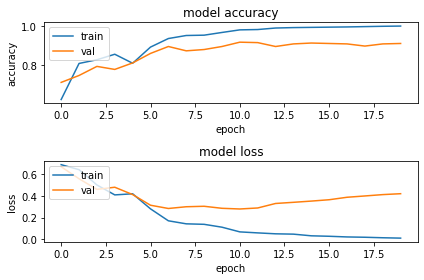

In [75]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.show()

In [29]:
print("{:.2f} seconds".format(time.time() - start_time))

966.89 seconds


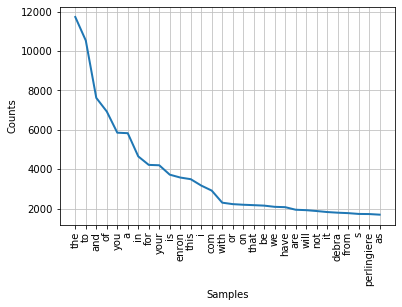

In [32]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import nltk



tokenized_word=[]
fdist = FreqDist()
for i in Corpus.email:
  
    for word in word_tokenize(i):
        fdist[word] += 1
        
fdist.plot(30,cumulative=False)
plt.show()

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
# CHANGE TO CODE 
from os import listdir
from os import path

start_time = time.time()
input_path = 'input/batches/'
paths = listdir(input_path)
number_of_runs= 49
total = 0
total_acc = 0
points=[]

press1T=0.0; recall1T=0.0; f1_s1T=0.0; supp1T=0.0
press2T=0.0; recall2T=0.0; f1_s2T=0.0; supp2T=0.0
f1_s3T=0.0; supp3T=0.0
press4T=0.0; recall4T=0.0; f1_s4T=0.0; supp4T=0.0
press5T=0.0; recall5T=0.0; f1_s5T=0.0; supp5T=0.0


mat = np.zeros((2, 2))

start_time = time.time()

for i in range(number_of_runs):
    if '.ipynb_checkpoints' in paths[i]:
        continue
    
    corpus = pd.read_csv(input_path+paths[i],encoding = "latin")
    X = Corpus.email.astype(str) # data
    Y = Corpus.category  # labels
    # label enconder from pandas to an array
    le = LabelEncoder()
    Y = le.fit_transform(Y)

    # transfor from a array to a vector
    Y = Y.reshape(-1,1)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=20)    
    
    #Tokenize the data and convert the text to sequences.
    tok.fit_on_texts(X_train)
    sequences = tok.texts_to_sequences(X_train)

    # Add padding to ensure that all the sequences have the same shape.
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

    # Process the test set data.
    test_sequences = tok.texts_to_sequences(X_test)
    test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
    # Call the function and compile the model.
    model1 = LSTM_model()
    #model.summary()
    model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
    history = model1.fit(sequences_matrix,
                    Y_train,
                    batch_size=256,
                    epochs=2,
                    validation_split=0.2,
                    verbose=0)
    # Evaluate the model on the test set.
    # Final Result - Generalization!
    #score = model.evaluate(test_sequences_matrix, Y_test, verbose=0) 
    #print('Test accuracy:', score[1])
    yhat = model1.predict(test_sequences_matrix)
    acc =accuracy_score(Y_test, yhat.round())
    
    class_report = classification_report(Y_test, yhat.round())
    class_report = class_report.split('\n')
    
    press1, recall1, f1_s1, supp1 =  [float(i) for i in class_report[2].split()[1:]]
    press1T+=press1; recall1T+=recall1; f1_s1T+=f1_s1; supp1T+=supp1
    
    press2, recall2, f1_s2, supp2 =  [float(i) for i in class_report[3].split()[1:]]
    press2T+=press2; recall2T+=recall2; f1_s2T+=f1_s2; supp2T+=supp2
    
    f1_s3, supp3 = [float(i) for i in class_report[5].split()[1:]]
    f1_s3T+=f1_s3; supp3T+=supp3
    
    press4, recall4, f1_s4, supp4 = [float(i) for i in class_report[6].split()[2:]]
    press4T+=press4; recall4T+=recall4; f1_s4T+=f1_s4; supp4T+=supp4
    
    
    press5, recall5, f1_s5, supp5 = [float(i) for i in class_report[7].split()[2:]]
    press5T+=press5; recall5T+=recall5; f1_s5T+=f1_s5; supp5T+=supp5
    
    con_mat = confusion_matrix(Y_test, yhat.round())  
    for i in range(len(mat)):
        for j in range(len(mat[i])):
            mat[i][j] += con_mat[i][j]
            
    points.append(acc)
    total_acc+=acc
    total +=1 
    
print("-> Accuracy",total_acc/total)

print("{:.2f} seconds".format(time.time() - start_time))  

-> Accuracy 0.8039044289044287
3586.15 seconds


In [98]:
# the 3 lines below show how to invoke various output    
print("-> Accuracy",total_acc/total)

print("\n"," -> Classification Report\n")

print('{0:13} {1:12s} {2:7s} {3:10s} {4:8s}'.format(' ' , 'precision', 'recall', 'f1-score' , 'support'))

print('{0:9}  {1:6s} {2:5.2f} {3:9.2f} {4:9.2f} {5:9.0f}'.format( ' ','0',press1T/total, recall1T/total, f1_s1T/total, supp1T/total))
print('{0:9}  {1:6s} {2:5.2f} {3:9.2f} {4:9.2f} {5:9.0f}\n'.format( ' ','1',press2T/total, recall2T/total, f1_s2T/total, supp2T/total))
print('{0:2}  {1:33s} {2:5.2f} {3:9.0f}'.format( ' ','accuracy',f1_s3T/total, supp3T/total))
print('{0:1}  {1:14s} {2:5.2f} {3:9.2f} {4:9.2f} {5:9.0f}'.format( ' ','macro avg',press4T/total, recall4T/total, f1_s4T/total, supp4T/total))
print('{0:17s} {1:5.2f} {2:9.2f} {3:9.2f} {4:9.0f}'.format( 'weighted avg',press5T/total, recall5T/total, f1_s5T/total, supp5T/total))

print("\n","-> Classification Report\n")

print('{0:.0f}  {1:.0f}'.format(mat[0][0], mat[0][1]))
print('{0:.0f}  {1:.0f}'.format(mat[1][0], mat[1][1]))

-> Accuracy 0.8039044289044287

  -> Classification Report

              precision    recall  f1-score   support 
           0       0.88      0.78      0.81       312
           1       0.77      0.83      0.78       260

    accuracy                           0.80       572
   macro avg       0.83      0.81      0.79       572
weighted avg       0.83      0.80      0.80       572

 -> Classification Report

11687  3289
2095  10385


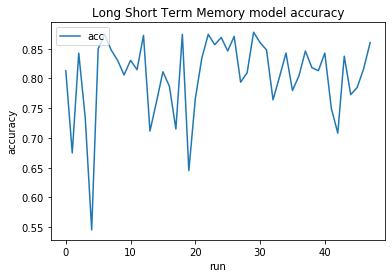

In [100]:
# summarize history for accuracy

plt.plot(points) 
plt.title('Long Short Term Memory model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('run')
plt.legend(['acc'], loc='upper left')

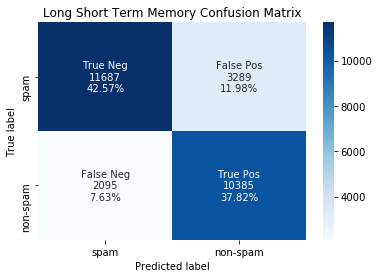

In [102]:
import seaborn as sns
cf_matrix = np.array([[11687,  3289], [2095, 10385]])
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['spam', 'non-spam']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels,xticklabels=categories, yticklabels=categories, fmt='', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Long Short Term Memory Confusion Matrix")
plt.show()
